In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_parquet('cleaned.parquet')

non_factor_cols = {'permno', 'yyyymm', 'monthid', 'ticker', 'conm', 'gvkey', 'cusip', 'naics', 'gsubind', 'PRC', 'RET', 'SHROUT', 'ret_f1', 'ret_f2', 'ret_f3', 'ret_f4', 'ret_f5', 'ret_f6', 'ret_f7', 'ret_f8', 'ret_f9', 'ret_f10', 'ret_f11', 'ret_f12', 'date_x', 'fdate', 'ret', 'date_y', 'date'}
factor_cols = set(data.columns) - non_factor_cols

In [3]:
# Select a sample factor column to demonstrate

def summarize(factor):
	print(data[factor].describe())

composite_factors = [
    "mean_reversion_signal",
    "trend_factor",
    "RD_P",
    "SIR",
    "range_120",
    "range_20",
    "Accrual",
    "FCF_P",
    "xret_indsize_std120",
    "RD_SALE",
]

for factor in composite_factors:
	summarize(factor)

count    81600.000000
mean         0.501838
std          0.196995
min          0.007353
25%          0.457721
50%          0.501838
75%          0.566176
max          0.996324
Name: mean_reversion_signal, dtype: float64
count    80501.000000
mean         0.501863
std          0.288675
min          0.007353
25%          0.251852
50%          0.501845
75%          0.752101
max          0.996324
Name: trend_factor, dtype: float64
count    81578.000000
mean         0.501839
std          0.229882
min          0.294118
25%          0.363469
50%          0.378676
75%          0.742647
max          0.996324
Name: RD_P, dtype: float64
count    43670.000000
mean         0.501843
std          0.288676
min          0.007353
25%          0.250923
50%          0.501845
75%          0.752768
max          0.996324
Name: SIR, dtype: float64
count    81596.000000
mean         0.501838
std          0.288674
min          0.007353
25%          0.252322
50%          0.501852
75%          0.751389
max       

## Test/Train Split

In [4]:
unique_dates = sorted(data['yyyymm'].unique())
training_ratio = 4/5

split_index = int(len(unique_dates) * training_ratio)
split_date = unique_dates[split_index]
print(f"Split at yyyymm: {split_date}")

Split at yyyymm: 201501


## Raw Predictive Power

In [5]:
def calculate_univariate_power(data, factor_cols):
    results = {
        'factor': [],
        'avg_coef': [],
        't_stat': [],
        'p_value': []
    }
    months = sorted(data['yyyymm'].unique())

    # For each factor, run monthly cross-sectional regressions
    for factor in factor_cols:
        coefs = []

        for month in months:
            month_data = data[data['yyyymm'] == month].copy()

            if len(month_data) < 10: # At least 10 data points before proceeding
                   continue

            X = month_data[[factor]].copy()
            X = sm.add_constant(X)
            #y = month_data[target_column]

            y = month_data['ret_f1'] # Predicting next month's returns
            if X.isnull().values.any() or y.isnull().values.any():
                   continue

            model = sm.OLS(y, X).fit()
            if len(model.params) < 2:
                   continue
            coefs.append(model.params.iloc[1])  # Index 1 is the factor coefficient (0 is intercept)

        if len(coefs) > 0:
            avg_coef = np.mean(coefs)
            std_coefs = np.std(coefs)

            if std_coefs > 0:
                t_stat = (avg_coef / std_coefs) * np.sqrt(len(coefs))
                p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=len(coefs)-1))
            else:
                # Handle the case where all coefficients are identical
                if avg_coef != 0:
                    # If all coefficients are non-zero and identical, this is strong evidence
                    t_stat = np.inf if avg_coef > 0 else -np.inf
                    p_value = 0.0
                else:
                    # If all coefficients are zero, no effect
                    t_stat = 0.0
                    p_value = 1.0

            results['factor'].append(factor)
            results['avg_coef'].append(avg_coef)
            results['t_stat'].append(t_stat)
            results['p_value'].append(p_value)

    results_df = pd.DataFrame(results)
    results_df['abs_t_stat'] = results_df['t_stat'].abs()
    results_df = results_df.sort_values('abs_t_stat', ascending=False)

    return results_df

In [6]:
factor_power_1m = calculate_univariate_power(data, factor_cols)

with pd.ExcelWriter('factor_analysis.xlsx') as writer:
    factor_power_1m.to_excel(writer, sheet_name='univariate_power_1m', index=False)

In [ ]:
lookbacks = [3, 6, 9, 12]
factor_power = []

for lookback_window in lookbacks:
    temp_data = data.copy()

    for factor in factor_cols:
        temp_data[f'{factor}'] = (
            temp_data.groupby('permno')[factor]
            .transform(lambda x: x.rolling(lookback_window).mean())
        )

    factor_power = calculate_univariate_power(temp_data, factor_cols)
    
    with pd.ExcelWriter('factor_analysis.xlsx', mode='a') as writer:
    	factor_power.to_excel(writer, sheet_name=f'univariate_power_{lookback_window}m', index=False)

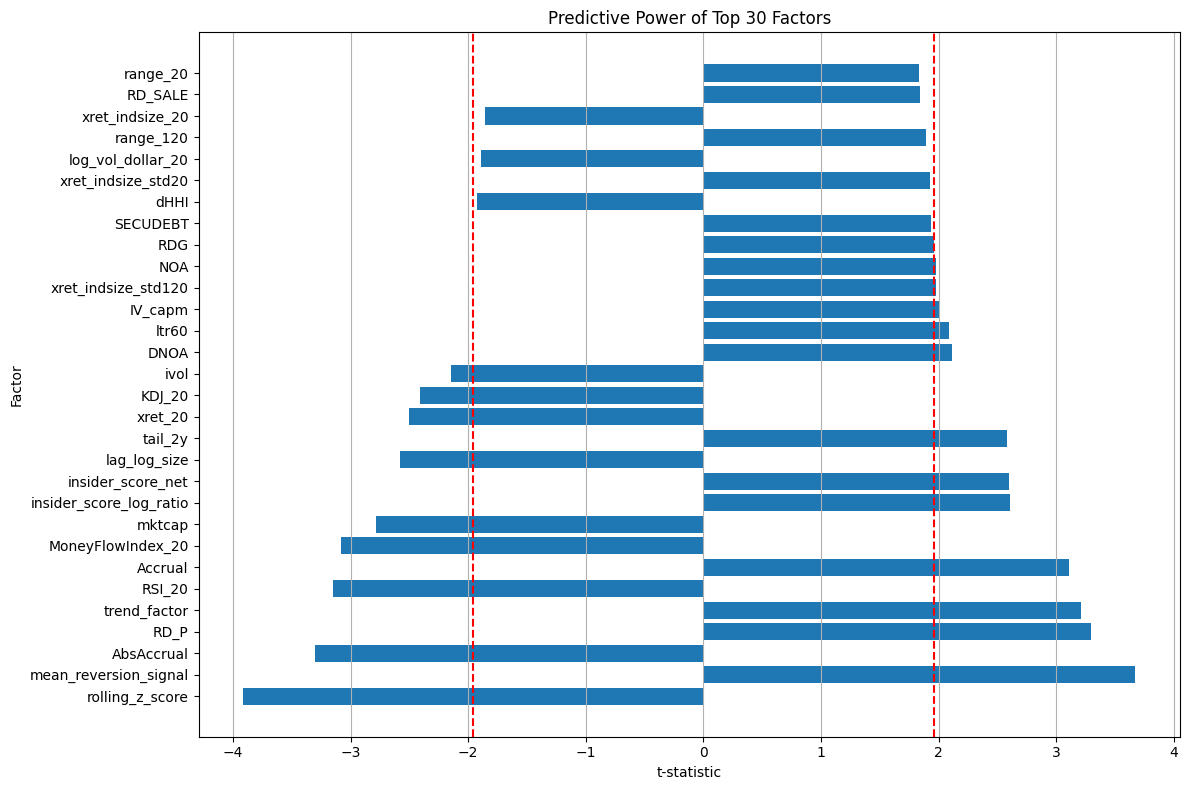

In [7]:
# Plot t-statistics of top 30 factors
top_factors = factor_power_1m.head(30)

plt.figure(figsize=(12, 8))
plt.barh(top_factors['factor'], top_factors['t_stat'])
plt.axvline(x=1.96, color='r', linestyle='--', label='95% significance')
plt.axvline(x=-1.96, color='r', linestyle='--')
plt.title('Predictive Power of Top 30 Factors')
plt.xlabel('t-statistic')
plt.ylabel('Factor')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

## Information Coefficient

Overview
- Convert both the factor values and next month returns to ranks
- Calculate the Pearson correlation between these ranks
- Less affected by outliers than regression coefficients
- Not to be confused with Information Ratio from class

In [8]:
def calculate_monthly_ics(data, factor_cols):
    results = {
        'factor': [],
        'avg_ic': [],
        'ic_t_stat': [],
        'ic_hit_rate': [],  # % of months with expected sign
        'avg_abs_ic': []
    }
    
    months = sorted(data['yyyymm'].unique())
    
    for factor in factor_cols:
        monthly_ics = []
        
        for month in months[:-1]:  # Skip the last month
            month_data = data[data['yyyymm'] == month].copy()
            
            if len(month_data) < 30:
                continue
                
            # Calculate rank correlation between factor and next month's returns
            ic = month_data[[factor, 'ret_f1']].corr(method='spearman').iloc[0, 1]
            
            if not np.isnan(ic):
                monthly_ics.append(ic)
        
        if monthly_ics:
            avg_ic = np.mean(monthly_ics)
            ic_std = np.std(monthly_ics)
            ic_t_stat = avg_ic / (ic_std / np.sqrt(len(monthly_ics)))
            hit_rate = sum(1 for ic in monthly_ics if np.sign(ic) == np.sign(avg_ic)) / len(monthly_ics)
            
            results['factor'].append(factor)
            results['avg_ic'].append(avg_ic)
            results['ic_t_stat'].append(ic_t_stat)
            results['ic_hit_rate'].append(hit_rate)
            results['avg_abs_ic'].append(np.mean(np.abs(monthly_ics)))
    
    return pd.DataFrame(results)

In [9]:
factor_ic = calculate_monthly_ics(data, factor_cols)

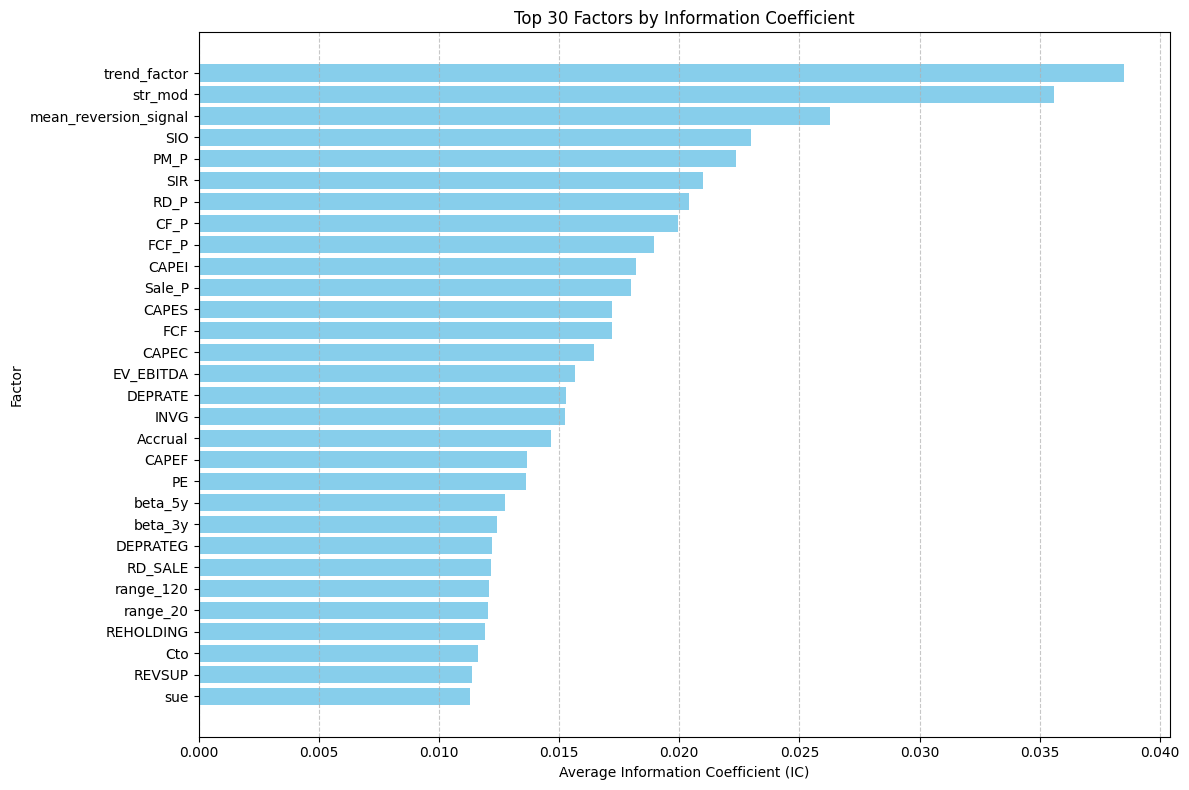

In [10]:
top_30_ic_factors = factor_ic.sort_values('avg_ic', ascending=False).head(30)

plt.figure(figsize=(12, 8))
plt.barh(top_30_ic_factors['factor'], top_30_ic_factors['avg_ic'], color='skyblue')
plt.xlabel('Average Information Coefficient (IC)')
plt.ylabel('Factor')
plt.title('Top 30 Factors by Information Coefficient')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest IC at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
with pd.ExcelWriter('factor_analysis.xlsx', mode='a') as writer:
    factor_ic.to_excel(writer, sheet_name='information_coefficient')

## Time Decay

Are any factors losing their predictive power in recent time periods?

In [ ]:
def analyze_time_decayed_significance(data, factor_cols, decay_half_life=48):
    results = {
        'factor': [],
        'weighted_t_stat': [],
        'recent_t_stat': [],
        'full_t_stat': []
    }
    
    # Define timeframes
    all_months = sorted(data['yyyymm'].unique())
    total_months = len(all_months)
    recent_cutoff = all_months[int(total_months * 0.75)]  # Use last 25% as "recent"
    
    for factor in factor_cols:
        monthly_coeffs = []
        monthly_dates = []
        
        # Calculate monthly coefficients
        for month in all_months:
            month_data = data[data['yyyymm'] == month].copy()
            
            if len(month_data) < 10:
                continue
                
            X = month_data[[factor]].copy()
            X = sm.add_constant(X)
            y = month_data['ret_f1']
            
            if X.isnull().values.any() or y.isnull().values.any():
                continue
                
            model = sm.OLS(y, X).fit()
            if len(model.params) < 2:
                continue
                
            monthly_coeffs.append(model.params.iloc[1])
            monthly_dates.append(month)
        
        if len(monthly_coeffs) > 10:  # Need reasonable sample size
            # Calculate traditional t-stat
            full_mean = np.mean(monthly_coeffs)
            full_std = np.std(monthly_coeffs)
            if full_std > 0:
                full_t_stat = (full_mean / full_std) * np.sqrt(len(monthly_coeffs))
            else:
                if full_mean != 0:
                    full_t_stat = np.inf if full_mean > 0 else -np.inf
                else:
                    full_t_stat = 0.0
            
            # Calculate recent t-stat
            recent_indices = [i for i, date in enumerate(monthly_dates) if date >= recent_cutoff]
            if recent_indices:
                recent_coeffs = [monthly_coeffs[i] for i in recent_indices]
                recent_mean = np.mean(recent_coeffs)
                recent_std = np.std(recent_coeffs)
                recent_t_stat = (recent_mean / recent_std) * np.sqrt(len(recent_coeffs))
            else:
                recent_t_stat = 0
            
            # Calculate time-decayed t-stat - Modified approach
            weights = []
            latest_month_idx = len(monthly_dates) - 1
            
            for idx, _ in enumerate(monthly_dates):
                # Use simple distance in months index rather than actual date differences
                months_ago = latest_month_idx - idx  
                weight = np.power(0.5, months_ago / decay_half_life)
                weights.append(weight)
                
            weights = np.array(weights) / sum(weights)  # Normalize weights
            weighted_mean = np.sum(np.array(monthly_coeffs) * weights)
            
            # Alternative variance calculation for weighted data
            weighted_var = np.sum(weights * np.power(np.array(monthly_coeffs) - weighted_mean, 2)) / (1 - np.sum(np.power(weights, 2)))
            weighted_std = np.sqrt(weighted_var)
            
            # Effective sample size for weighted data
            n_eff = 1 / np.sum(np.power(weights, 2))
            weighted_t_stat = weighted_mean / (weighted_std / np.sqrt(n_eff))
            
            results['factor'].append(factor)
            results['weighted_t_stat'].append(weighted_t_stat)
            results['recent_t_stat'].append(recent_t_stat)
            results['full_t_stat'].append(full_t_stat)
            
    results_df = pd.DataFrame(results)
    
    # Add a "factor health" metric
    results_df['factor_health'] = results_df['recent_t_stat'] / results_df['full_t_stat']
    
    return results_df

In [13]:
factor_decay = analyze_time_decayed_significance(data, factor_cols)

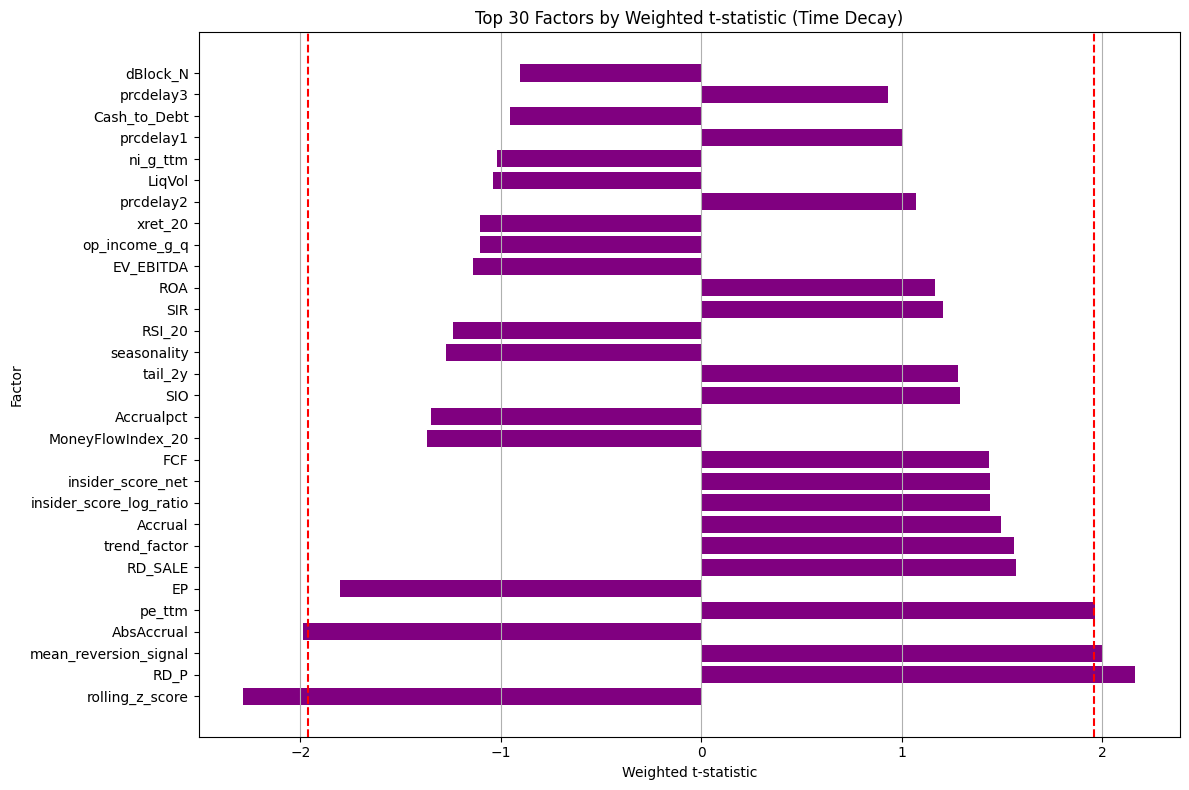

In [14]:
# Calculate absolute weighted t-statistic
factor_decay['abs_weighted_t_stat'] = factor_decay['weighted_t_stat'].abs()

# Sort by absolute weighted t-statistic and select top 30
top_weighted_factors = factor_decay.sort_values('abs_weighted_t_stat', ascending=False).head(30)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(top_weighted_factors['factor'], top_weighted_factors['weighted_t_stat'], color='purple')
plt.axvline(x=1.96, color='r', linestyle='--', label='95% significance')
plt.axvline(x=-1.96, color='r', linestyle='--')
plt.title('Top 30 Factors by Weighted t-statistic (Time Decay)')
plt.xlabel('Weighted t-statistic')
plt.ylabel('Factor')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

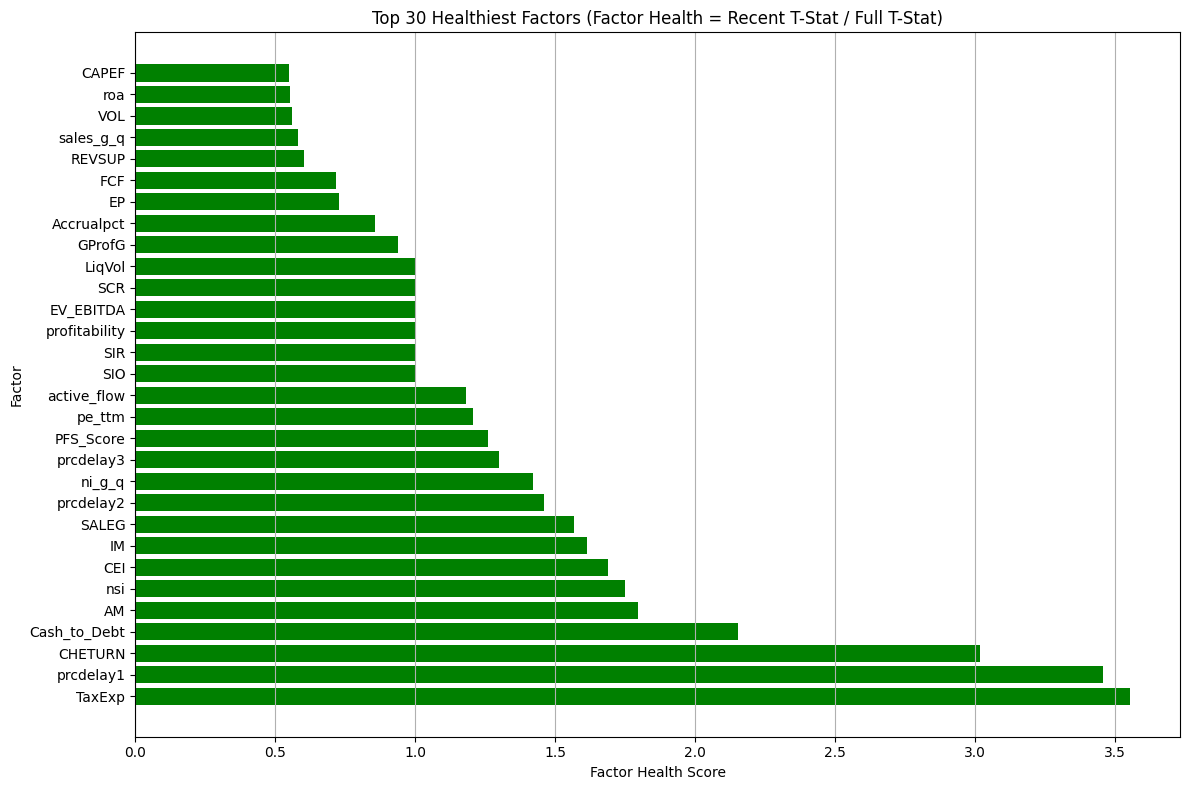

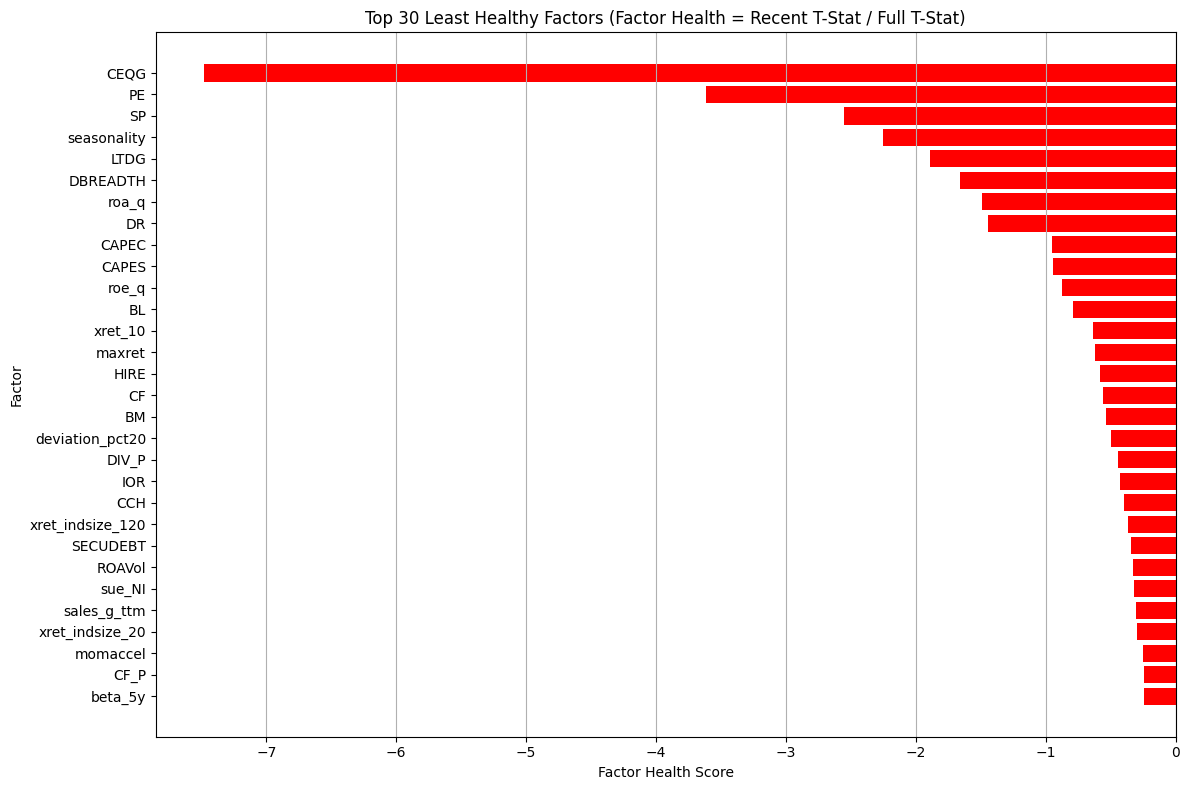

In [16]:
# Ensure 'factor_health' is numeric and handle potential NaNs/Infs
factor_decay['factor_health'] = pd.to_numeric(factor_decay['factor_health'], errors='coerce')
plot_data = factor_decay.dropna(subset=['factor_health']).replace([np.inf, -np.inf], np.nan).dropna(subset=['factor_health'])

# Get top 30 healthiest factors
healthiest_factors = plot_data.sort_values('factor_health', ascending=False).head(31)[1:]

# Get top 30 least healthy factors (lowest health score)
least_healthy_factors = plot_data.sort_values('factor_health', ascending=True).head(30)

# Plot Healthiest Factors
plt.figure(figsize=(12, 8))
plt.barh(healthiest_factors['factor'], healthiest_factors['factor_health'], color='green')
plt.title('Top 30 Healthiest Factors (Factor Health = Recent T-Stat / Full T-Stat)')
plt.xlabel('Factor Health Score')
plt.ylabel('Factor')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Plot Least Healthy Factors
plt.figure(figsize=(12, 8))
# Use absolute value for bar length if health is negative, but keep original value for color/label context if needed
# Or just plot the negative values directly
plt.barh(least_healthy_factors['factor'], least_healthy_factors['factor_health'], color='red')
plt.title('Top 30 Least Healthy Factors (Factor Health = Recent T-Stat / Full T-Stat)')
plt.xlabel('Factor Health Score')
plt.ylabel('Factor')
plt.grid(axis='x')
# Invert y-axis so the lowest score is at the top, matching the sort order
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [17]:
with pd.ExcelWriter('factor_analysis.xlsx', mode='a') as writer:
    factor_decay.to_excel(writer, sheet_name='factor_decay')

## Factor Scorecards

Combine all previous analysis

In [18]:
def create_factor_scorecards(univariate_results, ic_results, decay_results):
    # Merge all results
    combined = univariate_results.merge(
        ic_results, on='factor', how='inner'
    ).merge(
        decay_results, on='factor', how='inner'
    )
    
    # Create normalized scores (0-100) for key metrics
    metrics = [
        ('abs_t_stat', True),       # Higher is better
        ('avg_abs_ic', True),       # Higher is better
        ('ic_hit_rate', True),      # Higher is better
        ('weighted_t_stat', True),  # Higher is better
        ('factor_health', True),    # Higher is better
    ]
    
    for metric, higher_is_better in metrics:
        if higher_is_better:
            combined[f'{metric}_score'] = 100 * (combined[metric] - combined[metric].min()) / (combined[metric].max() - combined[metric].min() + 1e-10)
        else:
            combined[f'{metric}_score'] = 100 * (combined[metric].max() - combined[metric]) / (combined[metric].max() - combined[metric].min() + 1e-10)
    
    # Create composite score
    score_columns = [f'{metric}_score' for metric, _ in metrics]
    combined['composite_score'] = combined[score_columns].mean(axis=1)
    
    return combined.sort_values('composite_score', ascending=False)

In [20]:
scorecard = create_factor_scorecards(factor_power_1m, factor_ic, factor_decay)
scorecard.head(10)

,factor,avg_coef,t_stat,p_value,abs_t_stat,avg_ic,ic_t_stat,ic_hit_rate,avg_abs_ic,weighted_t_stat,recent_t_stat,full_t_stat,factor_health,abs_weighted_t_stat,abs_t_stat_score,avg_abs_ic_score,ic_hit_rate_score,weighted_t_stat_score,factor_health_score,composite_score
1,mean_reversion_signal,0.009125,3.671686,0.000292,3.671686,0.026276,3.784979,0.593156,0.089127,1.999090,1.610162,3.671686,0.438535,1.999090,93.793006,22.337370,97.046330,96.264906,39.724996,69.833322
4,trend_factor,0.009255,3.207710,0.001529,3.207710,0.038504,4.065000,0.571906,0.130349,1.560701,0.961675,3.207710,0.299801,1.560701,81.869546,48.272245,80.539366,86.413935,39.028718,67.224762
3,RD_P,0.009575,3.291136,0.001125,3.291136,0.020390,2.892992,0.568562,0.099484,2.165309,1.341901,3.291136,0.407732,2.165309,84.013462,28.853710,77.941322,100.000000,39.570402,66.075779
6,Accrual,0.005248,3.105790,0.002130,3.105790,0.014685,2.711054,0.595318,0.075714,1.496835,0.541761,3.105790,0.174436,1.496835,79.250369,13.898656,98.725674,84.978814,38.399535,63.050610
26,range_120,0.007881,1.890471,0.059668,1.890471,0.012072,0.859975,0.541806,0.197707,0.170275,-0.352440,1.890471,-0.186429,0.170275,48.018586,90.650797,57.156969,55.169883,36.588423,57.516932
29,range_20,0.007461,1.835105,0.067493,1.835105,0.012047,0.899564,0.545151,0.187582,0.232076,-0.350294,1.835105,-0.190885,0.232076,46.595763,84.280290,59.755013,56.558611,36.566063,56.751148
19,xret_indsize_std120,0.007311,1.977498,0.048910,1.977498,0.010764,0.862199,0.548495,0.179662,0.164219,-0.385152,1.977498,-0.194767,0.164219,50.255048,79.297404,62.353057,55.033791,36.546577,56.697176
28,RD_SALE,0.004727,1.839143,0.066949,1.839143,0.012169,1.562624,0.558528,0.109096,1.571340,0.950756,1.839143,0.516956,1.571340,46.699550,34.900831,70.147190,86.653001,40.118576,55.703829
0,rolling_z_score,-0.009012,-3.913218,0.000116,3.913218,-0.034779,-3.968332,0.596958,0.110968,-2.284900,-1.811547,-3.913218,0.462930,2.284900,100.000000,36.078942,100.000000,0.000000,39.847431,55.185275
40,FCF_P,0.003480,1.638005,0.102540,1.638005,0.018943,2.483451,0.581940,0.108733,0.854481,0.741729,1.638005,0.452825,0.854481,41.530616,34.672493,88.333498,70.544581,39.796714,54.975580


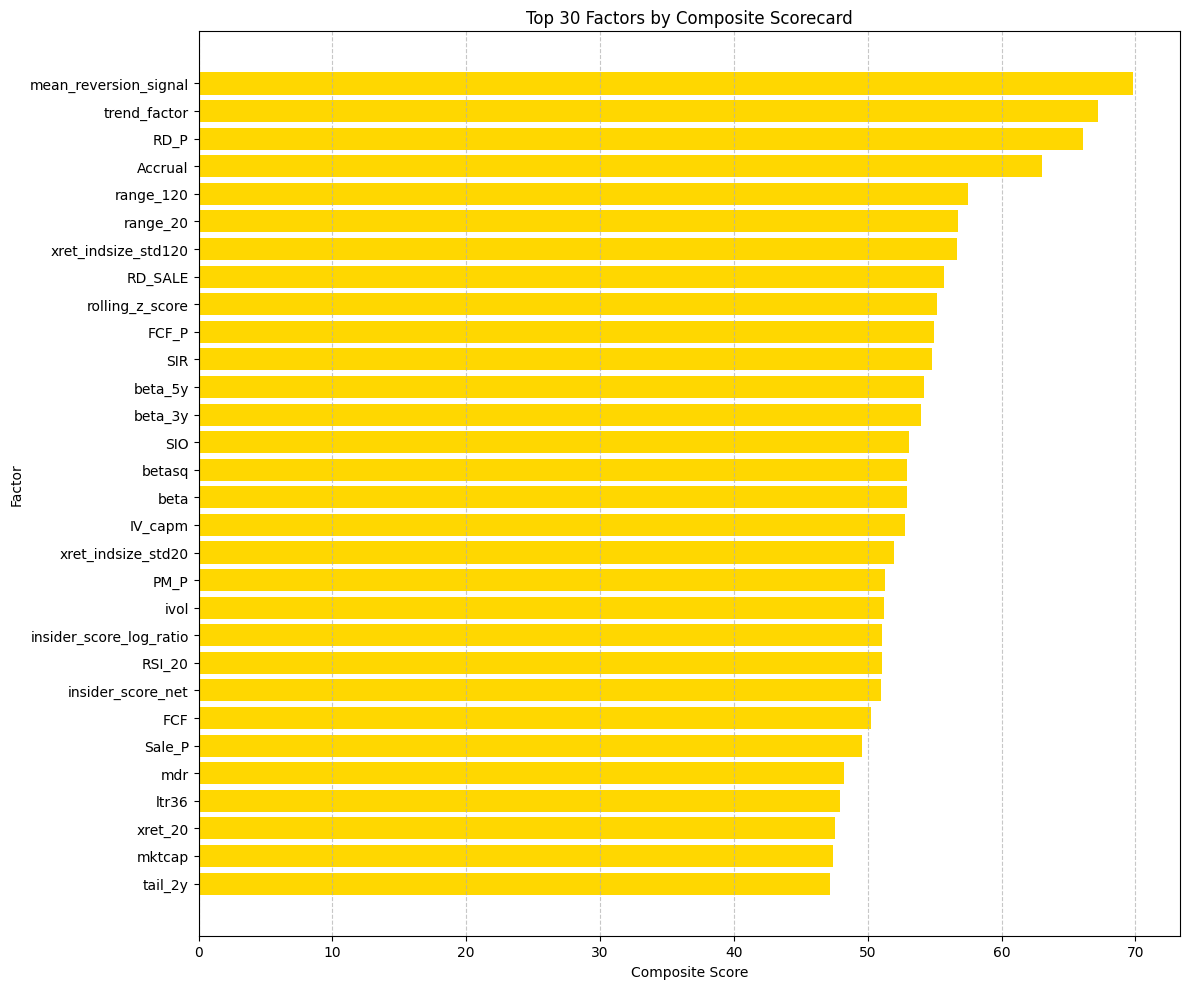

In [21]:
top_scorecard_factors = scorecard.head(30)

# Plot
plt.figure(figsize=(12, 10))
plt.barh(top_scorecard_factors['factor'], top_scorecard_factors['composite_score'], color='gold')
plt.xlabel('Composite Score')
plt.ylabel('Factor')
plt.title('Top 30 Factors by Composite Scorecard')
plt.gca().invert_yaxis()  # Show highest score at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [22]:
with pd.ExcelWriter('factor_analysis.xlsx', mode='a') as writer:
    scorecard.to_excel(writer, sheet_name='scorecard')